In [101]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

In [102]:
from IPython.display import display, Math
from pydrake.examples.pendulum import PendulumPlant, PendulumParams
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape


In [103]:
k = 0.4
m = 1
gamma = 0.2

In [105]:
prog = MathematicalProgram()
s = prog.NewIndeterminates(1, 's')[0]
sdot = prog.NewIndeterminates(1, 'sdot')[0]
x = np.hstack([s, sdot])

f = np.array([[Polynomial(sdot*1)], 
              [Polynomial(-(k/m)*s - (gamma/m)*sdot)]])

V, Q = prog.NewSosPolynomial(Variables(x), 2)
Vdot = V.Jacobian(x).dot(f)
Vdot = Vdot[0]

eps = 1e-4
prog.AddSosConstraint(-Vdot - eps*Polynomial(x.dot(x)))

prog.AddLinearConstraint(V.ToExpression().Substitute({s:0, sdot:0}) == 0)
prog.AddLinearConstraint(V.ToExpression().Substitute({s:1, sdot:0}) == k/2)


solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

In [106]:
Vsol = result.GetSolution(V)

<IPython.core.display.Javascript object>


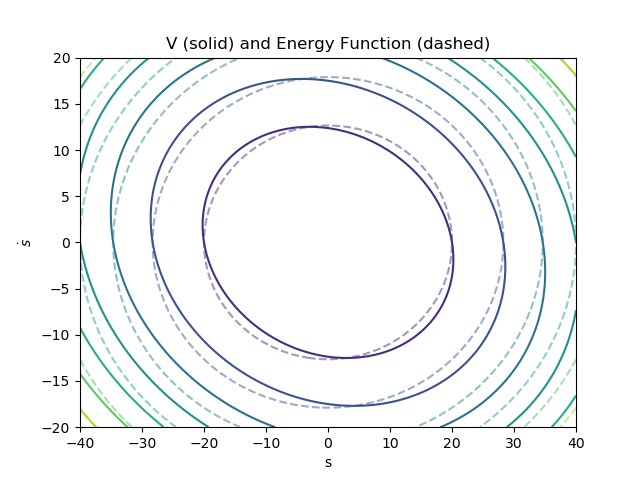

Text(0.5, 1.0, 'V (solid) and Energy Function (dashed)')

In [107]:
ns = 150
nsdot = 150

ss = np.linspace(-40, 40, ns)
sdots = np.linspace(-20, 20, nsdot)

S, Sdot = np.meshgrid(ss, sdots)
Vplot = S.copy()
Energy = 0.5*k*S**2 + 0.5*m*Sdot**2

env = {s:0, sdot:0}
for i in range(len(ss)): 
    for j in range(len(sdots)): 
        env[s] = S[i, j]
        env[sdot] = Sdot[i, j]
        Vplot[i, j] = Vsol.Evaluate(env)
        
        
fig, ax = plt.subplots()
ax.contour(ss, sdots, Vplot)
ax.contour(ss, sdots, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("s")
ax.set_ylabel("$\dot{s}$")
ax.set_title("V (solid) and Energy Function (dashed)")

In [70]:
Vsol.RemoveTermsWithSmallCoefficients(1e-5)

<Polynomial "0.52278940574607302*sdot(0)^2 + 0.095843543512593637*s(0) * sdot(0) + 0.20000000002488064*s(0)^2">

In [15]:
Vsol

<Polynomial "7.8115306093510017e-11*1 + 1.0642764956302899e-19*sdot(0) + 0.43895816845724223*sdot(0)^2 + 1.0783780394103449e-19*s(0) + 0.28408437059862579*s(0) * sdot(0) + 0.50000000003905753*s(0)^2">

In [108]:
Vsol.RemoveTermsWithSmallCoefficients(1e-5)

<Polynomial "0.52275060226986481*sdot(0)^2 + 0.095895323076702094*s(0) * sdot(0) + 0.20000000002534365*s(0)^2">

Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))
V =
2.4401173919337911*1 + 0.12628047990191346*thetadot(0)^2 + -4.8801919013731938*c(0) + 2.4400745094394027*c(0)^2 + -1.5618554332154861e-06*s(0) + 0.070015481718552999*s(0) * thetadot(0) + 4.0193059825202922e-06*s(0) * c(0) + 2.4648841699216426*s(0)^2


/tmp/ipykernel_3714/1382651291.py:34: RuntimeWarning: invalid value encountered in subtract
  constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))
/tmp/ipykernel_3714/1382651291.py:46: RuntimeWarning: invalid value encountered in subtract
  (x - x0).dot(x - x0) * s**2)


(2.440 - 0.000s_{0} - 4.880c_{0} + 0.000s_{0} c_{0} + 0.070s_{0} thetadot_{0} + 2.465s_{0}^{2} + 2.440c_{0}^{2} + 0.126thetadot_{0}^{2})

<IPython.core.display.Javascript object>


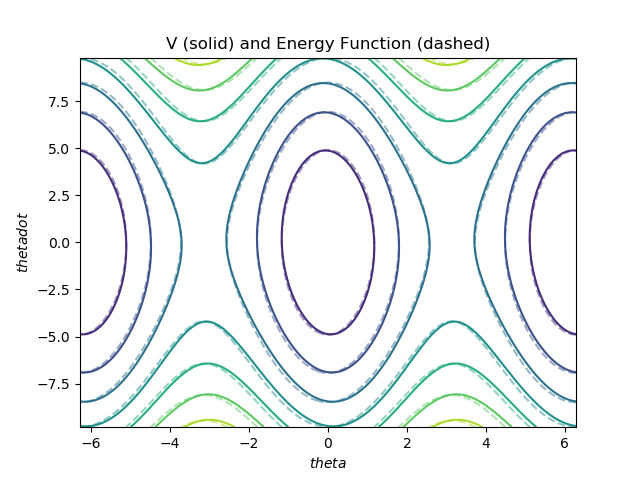

In [109]:
def global_pendulum():
    prog = MathematicalProgram()

    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s = prog.NewIndeterminates(1, "s")[0]
    c = prog.NewIndeterminates(1, "c")[0]
    thetadot = prog.NewIndeterminates(1, "thetadot")[0]
    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s, c, thetadot])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c * thetadot, -s * thetadot,
        (-p.damping() * thetadot - p.mass() * p.gravity() * p.length() * s) /
        (p.mass() * p.length() * p.length())
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also zero
    # at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multipling by s^2).
    constraint2 = prog.AddSosConstraint(-Vdot - L * (s**2 + c**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s**2)
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.                  

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({
            s: 0,
            c: 1,
            thetadot: 0
        }) == 0)

    # Add V(theta=pi/2) = mgl, just to set the scale.
    constraint4 = prog.AddLinearConstraint(
        V.Substitute({
            s: 1,
            c: 0,
            thetadot: 0
        }) == p.mass() * p.gravity() * p.length())

    # Call the solver.
    result = Solve(prog)
    assert result.is_success()

    # Note that I've added mgl to the potential energy (relative to the textbook),
    # so that it would be non-negative... like the Lyapunov function.
    mgl = p.mass() * p.gravity() * p.length()
    print("Mechanical Energy = ")
    print(.5 * p.mass() * p.length()**2 * thetadot**2 + mgl * (1 - c))

    print("V =")
    Vsol = Polynomial(result.GetSolution(V))
    print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))
    
    display(Markdown(ToLatex(Vsol.RemoveTermsWithSmallCoefficients(1e-6).ToExpression())))

    # Plot the results as contour plots.
    nq = 151
    nqd = 151
    q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
    qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * p.mass() * p.length()**2 * QD**2 + mgl * (1 - np.cos(Q))
    Vplot = Q.copy()
    env = {s: 0., c: 1., thetadot: 0}
    for i in range(nq):
        for j in range(nqd):
            env[s] = np.sin(Q[i, j])
            env[c] = np.cos(Q[i, j])
            env[thetadot] = QD[i, j]
            Vplot[i, j] = Vsol.Evaluate(env)

    # plt.rc("text", usetex=True)
    fig, ax = plt.subplots()
    ax.contour(Q, QD, Vplot)
    ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
    ax.set_xlabel("$theta$")
    ax.set_ylabel("$thetadot$")
    ax.set_title("V (solid) and Energy Function (dashed)")

global_pendulum()

In [75]:
p = PendulumParams()

In [79]:
p.gravity()

9.81

In [158]:
mp = 1
mc = 10
l = 0.5
gravity = 9.8

In [177]:
prog = MathematicalProgram()

# the state 
x_p = prog.NewIndeterminates(1, "x")[0]
x_pd = prog.NewIndeterminates(1, "\dot{x}")[0]
td = prog.NewIndeterminates(1, "\dot{t}")[0]
s = prog.NewIndeterminates(1, "s")[0]
c = prog.NewIndeterminates(1, "c")[0]

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, 1, 0, 0])

# the additional indeterminates
xd = prog.NewIndeterminates(5, "xd")
y = np.hstack([x, xd])
y_0 = np.hstack([x_0, np.zeros(5)])

M = np.array([[1, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0], 
              [0, 0, 1, 0, 0], 
              [0, 0, 0, mc+mp, l*mp*c], 
              [0, 0, 0, l*mp*c, l**2*mp]])

f = np.array([[x_pd], 
              [c*td], 
              [-s*td], 
              [mp*l*td**2*s], 
              [mp*l*x_pd*td*s - mp*gravity*l*s]])

g = np.reshape(M@xd, (5,1)) - f

eps = 1e-3

V_deg = 2
V = prog.NewFreePolynomial(Variables(y), V_deg)

Vdot = V.Jacobian(x).dot(xd)

trig = Polynomial(s**2 + c**2 - 1)
s_deg1 = max(1, V.TotalDegree() - trig.TotalDegree())
lambda_s1 = prog.NewFreePolynomial(Variables(y), s_deg1)

constraint1 = prog.AddSosConstraint(V)
# constraint1 = prog.AddSosConstraint(V- eps *Polynomial((x - x_0).dot(x - x_0) ))


lambda_gs = []
g_poly = []
for i in range(len(g)): 
    g_poly.append(Polynomial(g[i, 0]))
    l_g_deg = max(1, Vdot.TotalDegree() - g_poly[i].TotalDegree())
    lambda_gs.append(prog.NewFreePolynomial(Variables(y), l_g_deg))

g_poly = np.array(g_poly)
lambda_gs = np.array(lambda_gs)

s_deg = max(1, Vdot.TotalDegree() - trig.TotalDegree())
lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)

prog.AddSosConstraint(-Vdot + lambda_gs.dot(g_poly) + lambda_s*trig); 


constraint3 = prog.AddLinearConstraint(
        V.ToExpression().Substitute({x_p:0,s: 0,c: 1,x_pd: 0, td:0, \
                                     xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}) == 0)

constraint4 = prog.AddLinearConstraint(
        V.ToExpression().Substitute({x_p:0,s: 0,c: -1,x_pd: 0, td:0, \
                                    xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}) == mp*gravity*l)


solver = MosekSolver()
result = solver.Solve(prog)
assert result.is_success(), str(result.get_solver_details().solution_status)

/tmp/ipykernel_9827/848655019.py:30: RuntimeWarning: invalid value encountered in matmul
  g = np.reshape(M@xd, (5,1)) - f
/tmp/ipykernel_9827/848655019.py:30: RuntimeWarning: invalid value encountered in subtract
  g = np.reshape(M@xd, (5,1)) - f


AssertionError: 0

In [178]:
V_sol = result.GetSolution(V).RemoveTermsWithSmallCoefficients(1e-5)
h = Polynomial(0.5*(mc+mp)*x_pd**2 + 0.5*mp*l**2*td**2 + mp*l*x_pd*td*c - mp*l*gravity*c)

In [179]:
V_sol.indeterminates()

<Variables "{x(0), \dot{x}(0), \dot{t}(0), s(0), c(0), xd(0), xd(1), xd(2), xd(3), xd(4)}">

In [180]:
h.indeterminates()

<Variables "{\dot{x}(0), \dot{t}(0), c(0)}">

<IPython.core.display.Javascript object>


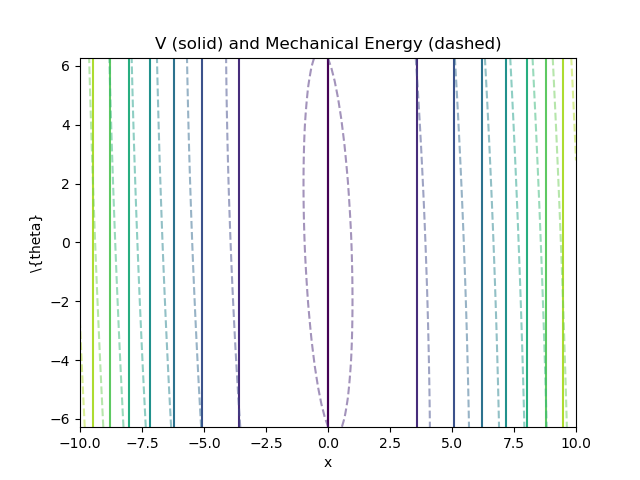

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [181]:
# Plot the results as contour plots.
n_disp = 151
n_theta = 151
disp = np.linspace(-10, 10, n_disp)
theta = np.linspace(-2*np.pi, 2*np.pi, n_theta)

Disp, Theta = np.meshgrid(disp, theta)
Vplot = Disp.copy()
hplot = Disp.copy()

env = {s: 0., c: 1., td: 0, x_p:0, x_pd:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}
for i in range(n_disp):
    for j in range(n_theta):
        env[td] = Theta[i,j]
        env[x_pd] = Disp[i, j]
        Vplot[i, j] = V_sol.Evaluate(env)
        hplot[i, j] = h.Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(Disp, Theta, Vplot)
ax.contour(Disp, Theta, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("x")
ax.set_ylabel("\{theta}")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

<IPython.core.display.Javascript object>


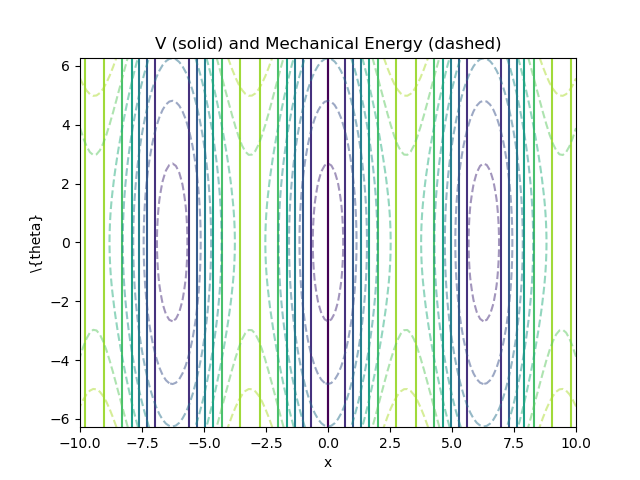

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [182]:
# Plot the results as contour plots.
n_disp = 151
n_theta = 151
disp = np.linspace(-10, 10, n_disp)
theta = np.linspace(-2*np.pi, 2*np.pi, n_theta)

Disp, Theta = np.meshgrid(disp, theta)
Vplot = Disp.copy()
hplot = Disp.copy()

env = {s: 0., c: 1., td: 0, x_p:0, x_pd:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}
for i in range(n_disp):
    for j in range(n_theta):
        env[td] = Theta[i,j]
        env[s] = np.sin(Disp[i, j])
        env[c] = np.cos(Disp[i, j])
        Vplot[i, j] = V_sol.Evaluate(env)
        hplot[i, j] = h.Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(Disp, Theta, Vplot)
ax.contour(Disp, Theta, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("x")
ax.set_ylabel("\{theta}")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [183]:
Vsol

<Polynomial "1.396247838648739e-10*1 + 4.1065982280499835e-20*qdot(0) + 1.003815704489526*qdot(0)^2 + -5.4615862206842292e-20*q(0) + 0.92600939720742792*q(0) * qdot(0) + 1.0701748981634216*q(0)^2">

<IPython.core.display.Javascript object>


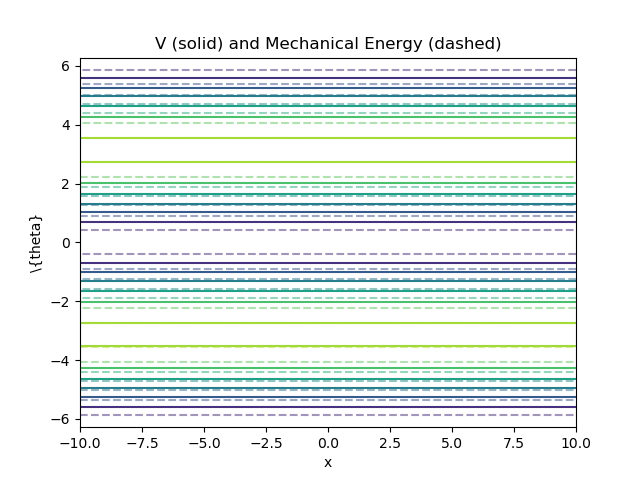

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [150]:
# Plot the results as contour plots.
n_disp = 151
n_theta = 151
disp = np.linspace(-10, 10, n_disp)
theta = np.linspace(-2 * np.pi, 2 * np.pi, n_theta)

Disp, Theta = np.meshgrid(disp, theta)
Vplot = Disp.copy()
hplot = Disp.copy()

env = {s: 0., c: 1., td: 0, x_p:0, x_pd:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}
for i in range(n_disp):
    for j in range(n_theta):
        env[s] = np.sin(Theta[i, j])
        env[c] = np.cos(Theta[i, j])
        env[x_p] = Disp[i, j]
        Vplot[i, j] = V_sol.Evaluate(env)
        hplot[i, j] = h.Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(Disp, Theta, Vplot)
ax.contour(Disp, Theta, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("x")
ax.set_ylabel("\{theta}")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [53]:
for thing in g: 
    display(Markdown(ToLatex(thing)))

\begin{bmatrix} ( - \dot{x}_{0} + xd_{0}) \end{bmatrix}

\begin{bmatrix} (xd_{1} - \dot{t}_{0} c_{0}) \end{bmatrix}

\begin{bmatrix} (xd_{2} + \dot{t}_{0} s_{0}) \end{bmatrix}

\begin{bmatrix} (11xd_{3} - 0.500\dot{t}_{0}^{2} s_{0} + 0.500c_{0} xd_{4}) \end{bmatrix}

\begin{bmatrix} (4.900s_{0} + 0.250xd_{4} - 0.500\dot{x}_{0} \dot{t}_{0} s_{0} + 0.500c_{0} xd_{3}) \end{bmatrix}

Cartpole Explicitly Done

In [173]:
prog = MathematicalProgram()
x_p = prog.NewIndeterminates(1, "x")[0]
x_pd = prog.NewIndeterminates(1, "\dot{x}")[0]
td = prog.NewIndeterminates(1, "\dot{t}")[0]
s = prog.NewIndeterminates(1, "s")[0]
c = prog.NewIndeterminates(1, "c")[0]

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, 1, 0, 0])

f = np.array([[x_pd*(mc+mp*s**2)*(l*(mc+mp*s**2))], 
              [c*td*(mc+mp*s**2)*(l*(mc+mp*s**2))], 
              [-s*td*(mc+mp*s**2)*(l*(mc+mp*s**2))], 
              [(mp*s*(l*td**2+gravity*c))*(mc+mp*s**2)], 
              [(-mp*l*td**2*c*s - (mc+mp)*gravity*s)*(l*(mc+mp*s**2))]])

V_deg = 2
V = prog.NewFreePolynomial(Variables(x), V_deg)

trig = Polynomial(s**2 + c**2 - 1)
s_deg1 = max(1, V.TotalDegree() - trig.TotalDegree())
lambda_s1 = prog.NewFreePolynomial(Variables(x), s_deg1)

eps = 1e-4
constraint1 = prog.AddSosConstraint(V + lambda_s1*trig )

constraint2 = prog.AddLinearConstraint(V.ToExpression().Substitute({x_p:0, s:0, c:-1, x_pd:0, td:0}) \
                                       == mp*gravity*l+l)

constraint3 = prog.AddLinearConstraint(V.ToExpression().Substitute({x_p:0, s:0, c:1, x_pd:0, td:0}) \
                                       == 0.01)

Vdot = V.ToExpression().Jacobian(x).dot(f)
Vdot = Polynomial(Vdot[0])

s_deg = max(1, Vdot.TotalDegree() - trig.TotalDegree())
lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)

constraint4 = prog.AddSosConstraint(-Vdot + lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success(), str(result.get_solver_details().solution_status)

AssertionError: 5

In [169]:
V_sol = result.GetSolution(V).RemoveTermsWithSmallCoefficients(1e-5)
h = Polynomial(0.5*(mc+mp)*x_pd**2 + 0.5*mp*l**2*td**2 + mp*l*x_pd*td*c - mp*l*gravity*c)

In [170]:
V_sol

<Polynomial "0.0075139588988730917*1 + 0.0024859559160732726*c(0)^2 + 0.0024859547330307991*s(0)^2">

In [162]:
h

<Polynomial "-4.9000000000000004*c(0) + 0.125*\dot{t}(0)^2 + 0.5*\dot{x}(0) * \dot{t}(0) * c(0) + 5.5*\dot{x}(0)^2">

<IPython.core.display.Javascript object>


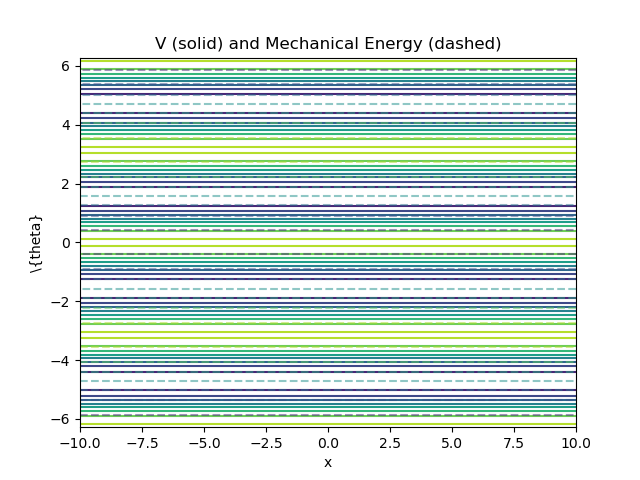

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [171]:
# Plot the results as contour plots.
n_disp = 151
n_theta = 151
disp = np.linspace(-10, 10, n_disp)
theta = np.linspace(-2 * np.pi, 2 * np.pi, n_theta)

Disp, Theta = np.meshgrid(disp, theta)
Vplot = Disp.copy()
hplot = Disp.copy()

env = {s: 0., c: 1., td: 0, x_p:0, x_pd:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}
for i in range(n_disp):
    for j in range(n_theta):
        env[s] = np.sin(Theta[i, j])
        env[c] = np.cos(Theta[i, j])
        env[x_p] = Disp[i, j]
        Vplot[i, j] = V_sol.Evaluate(env)
        hplot[i, j] = h.Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(Disp, Theta, Vplot)
ax.contour(Disp, Theta, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("x")
ax.set_ylabel("\{theta}")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

<IPython.core.display.Javascript object>


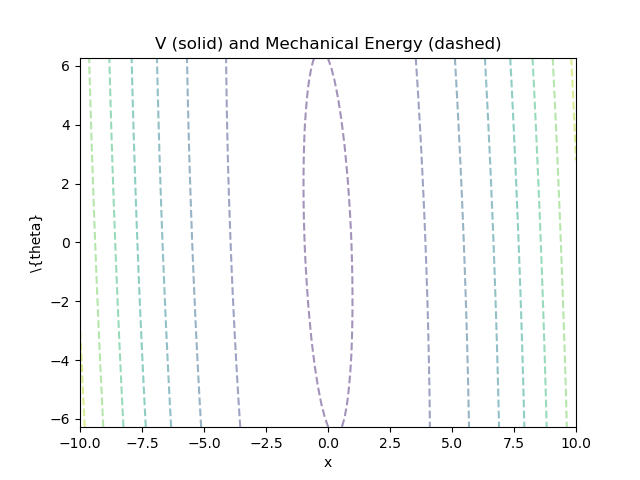

/tmp/ipykernel_9827/741416004.py:20: UserWarning: No contour levels were found within the data range.
  ax.contour(Disp, Theta, Vplot)


Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [172]:
# Plot the results as contour plots.
n_disp = 151
n_theta = 151
disp = np.linspace(-10, 10, n_disp)
theta = np.linspace(-2*np.pi, 2*np.pi, n_theta)

Disp, Theta = np.meshgrid(disp, theta)
Vplot = Disp.copy()
hplot = Disp.copy()

env = {s: 0., c: 1., td: 0, x_p:0, x_pd:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0}
for i in range(n_disp):
    for j in range(n_theta):
        env[td] = Theta[i,j]
        env[x_pd] = Disp[i, j]
        Vplot[i, j] = V_sol.Evaluate(env)
        hplot[i, j] = h.Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(Disp, Theta, Vplot)
ax.contour(Disp, Theta, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("x")
ax.set_ylabel("\{theta}")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [119]:
p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [123]:
p.l1()

1.0

In [111]:
b2

0.1

In [124]:
l2 = 2*lc2

In [151]:
prog = MathematicalProgram()
s1 = prog.NewIndeterminates(1, 's1')
c1 = prog.NewIndeterminates(1, 'c1')
s2 = prog.NewIndeterminates(1, 's2')
c2 = prog.NewIndeterminates(1, 'c2')
td1 = prog.NewIndeterminates(1, 't1d')
td2 = prog.NewIndeterminates(1, 't2d')

x = np.hstack([s1, c1, s2, c2, td1, td1])
x_0 = np.array([0, 1, 0, 1, 0, 0])

xd = prog.NewIndeterminates(6, 'xd')


y = np.hstack([x, xd])
y_0 = np.hstack([x_0, np.zeros(6)])

g0 = xd[0] - c1[0]*td1[0]
g1 = xd[1] + s1[0]*td1[0]
g2 = xd[2] - c2[0]*td2[0]
g3 = xd[3] + s2[0]*td2[0]
g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
        I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
            m2*l1*lc2*s2[0]*td2[0]**2 - \
                m1*gravity*lc1*s1[0] + m2*gravity*(l1*s1[0] + lc2*(s1[0]*c2[0] + c1[0]*s2[0])) - b1*td1[0]
g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
        m2*gravity*lc2*(s1[0]*c2[0] + c1[0]*s2[0]) - b2*td2[0]

g = np.array([g0, g1, g2, g3, g4, g5])

g_poly = []
for i in range(g.size):
    g_poly.append(Polynomial(g[i]))

g_poly = np.array(g_poly)

bottom_energy = m1*gravity*(l2+ lc1) + m2*gravity*(lc2)
Energy = 0.5*I1*td1[0]**2+0.5*(m2*l1**2+I2+2*m2*l1*lc2*c2[0])*td1[0]**2+0.5*I2*td2[0]**2 + \
            (I2+m2*l1*lc2*c2[0])*td1[0]*td2[0] + m1*gravity*(l1+l2 - lc1*c1[0]) \
                                + m2*gravity*(l1+l2 - l1*c1[0] - lc2*(c1[0]*c2[0]-s1[0]*s2[0])) - bottom_energy

V_deg = 2
V = prog.NewFreePolynomial(Variables(y), V_deg)
# V = Polynomial(Energy)

trig1 = Polynomial(s1[0]**2 + c1[0]**2 - 1)
trig2 = Polynomial(s2[0]**2 + c2[0]**2 - 1)

lambda_t1V = prog.NewFreePolynomial(Variables(y), 2)
lambda_t2V = prog.NewFreePolynomial(Variables(y), 2)

eps = 1e-4
sel_mul = Polynomial((y-y_0).dot(y-y_0))

constraint1 = prog.AddSosConstraint(V)
# constraint1 = prog.AddSosConstraint(V + lambda_t1V*trig1 + lambda_t2V*trig2)

top_energy = m1*gravity*(lc1+ l1 + l2)+m2*gravity*(2*l1+lc2 + l2)
bottom_energy = m1*gravity*(l2+ lc1) + m2*gravity*(lc2)

constraint2 = prog.AddLinearConstraint(
        V.ToExpression().Substitute({s1[0]: 0,c1[0]: 1, s2[0]: 0,c2[0]: 1, td1[0]: 0, td2[0]:0, \
                                     xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0, xd[5]:0}) == 0)   

# constraint3 = prog.AddLinearConstraint(
#         V.ToExpression().Substitute({s1[0]: 0,c1[0]: -1, s2[0]: 0,c2[0]: 1, td1[0]: 0, td2[0]:0, \
#                                      xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0, xd[5]:0}) == top_energy \
#                                                                                                 - bottom_energy)   

Vdot = V.Jacobian(x).dot(xd)

lambda_g = []
for i in range(g.size): 
    gi_deg = max(Vdot.TotalDegree() - g_poly[i].TotalDegree(), 1)
    lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
            
lambda_g = np.array(lambda_g)
lambda_t1 = prog.NewFreePolynomial(Variables(y), 2)
lambda_t2 = prog.NewFreePolynomial(Variables(y), 2)

constraint4 = prog.AddSosConstraint(-Vdot + lambda_g.dot(g_poly) \
                                    + lambda_t1*trig1 + lambda_t2*trig2)

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_acrobot.txt')

solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

assert result.is_success(), str(result.get_solver_details().solution_status)

/tmp/ipykernel_3714/3897282577.py:53: RuntimeWarning: invalid value encountered in subtract
  sel_mul = Polynomial((y-y_0).dot(y-y_0))


In [152]:
Vsol = result.GetSolution(V)

<IPython.core.display.Javascript object>


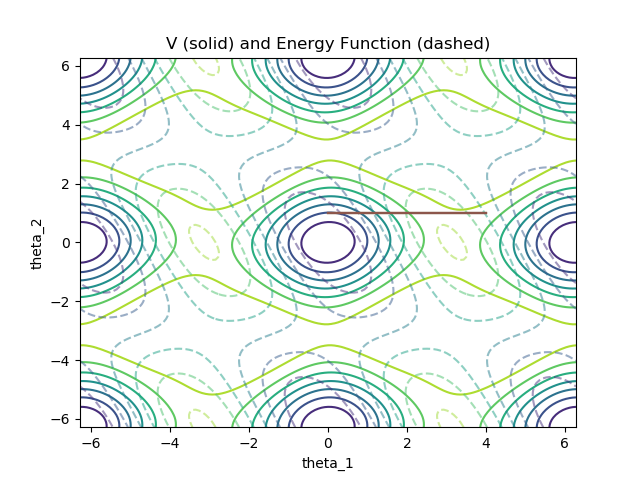

Text(0.5, 1.0, 'V (solid) and Energy Function (dashed)')

In [154]:
# Plot the results as contour plots.
nt1 = 151
nt2 = 151
t1 = np.linspace(-2 * np.pi, 2 * np.pi, nt1)
t2 = np.linspace(-2 * np.pi, 2 * np.pi, nt2)

T1, T2 = np.meshgrid(t1, t2)
Vplot = T1.copy()
hplot = T1.copy()

env = {s1[0]: 0,c1[0]: -1, s2[0]: 0,c2[0]: 1, td1[0]: 0, td2[0]:0, \
                                     xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0, xd[5]:0}
for i in range(nt1):
    for j in range(nt2):
        env[s1[0]] = np.sin(T1[i, j])
        env[c1[0]] = np.cos(T1[i, j])
        env[s2[0]] = np.sin(T2[i, j])
        env[c2[0]] = np.cos(T2[i, j])
        Vplot[i, j] = Vsol.Evaluate(env)
        hplot[i, j] = Polynomial(Energy).Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(T1, T2, Vplot)
ax.contour(T1, T2, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta_1")
ax.set_ylabel("theta_2")
ax.set_title("V (solid) and Energy Function (dashed)")

In [156]:
Vsol.RemoveTermsWithSmallCoefficients(1e-5)

<Polynomial "2.5157817878327462*xd(5)^2 + 3.0404596424460766*xd(4) * xd(5) + 2.5157272450412091*xd(4)^2 + 0.0095434746218926881*xd(3) + 0.00060026539428434454*xd(3) * xd(5) + 0.00047488329984194175*xd(3) * xd(4) + 6.0289567902506498*xd(3)^2 + 0.01038404535869086*xd(2) * xd(5) + 0.010395709119065172*xd(2) * xd(4) + -0.00048456310481790899*xd(2) * xd(3) + 3.9846199461067555*xd(2)^2 + 0.0082762540851985655*xd(1) + 0.00044518634419445937*xd(1) * xd(5) + 0.00045178585243850142*xd(1) * xd(4) + 0.95163687709135636*xd(1) * xd(3) + 0.00018386116246629617*xd(1) * xd(2) + 5.3886266979670747*xd(1)^2 + 1.1887940706238392e-05*xd(0) + 0.057858147866056482*xd(0) * xd(5) + 0.057908817560403857*xd(0) * xd(4) + 0.010825475208087961*xd(0) * xd(3) + 0.031235733256768723*xd(0) * xd(2) + 0.0014207694485984916*xd(0) * xd(1) + 4.919435074257863*xd(0)^2 + -0.0047597437418741822*t1d(0) * xd(5) + -0.0047597149890095669*t1d(0) * xd(4) + -1.5049698229715976e-05*t1d(0) * xd(2) + -6.6788074697600019e-05*t1d(0) * xd(0

<IPython.core.display.Javascript object>


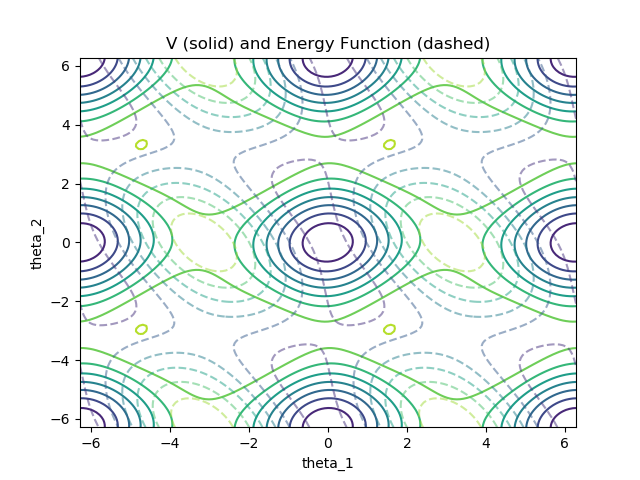

Text(0.5, 1.0, 'V (solid) and Energy Function (dashed)')

In [144]:
# Plot the results as contour plots.
nt1 = 151
nt2 = 151
t1 = np.linspace(-2 * np.pi, 2 * np.pi, nt1)
t2 = np.linspace(-2 * np.pi, 2 * np.pi, nt2)

T1, T2 = np.meshgrid(t1, t2)
Vplot = T1.copy()
hplot = T1.copy()

env = {s1[0]: 0,c1[0]: -1, s2[0]: 0,c2[0]: 1, td1[0]: 2, td2[0]:2, \
                                     xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, xd[4]:0, xd[5]:0}
for i in range(nt1):
    for j in range(nt2):
        env[s1[0]] = np.sin(T1[i, j])
        env[c1[0]] = np.cos(T1[i, j])
        env[s2[0]] = np.sin(T2[i, j])
        env[c2[0]] = np.cos(T2[i, j])
        Vplot[i, j] = Vsol.Evaluate(env)
        hplot[i, j] = Polynomial(Energy).Evaluate(env)
        
fig, ax = plt.subplots()
ax.contour(T1, T2, Vplot)
ax.contour(T1, T2, hplot, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta_1")
ax.set_ylabel("theta_2")
ax.set_title("V (solid) and Energy Function (dashed)")

##### -top_energy

In [31]:
np.hstack([x_0, np.zeros(6)])

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Example from HW 3

In [71]:
gamma = 1
k = 1
m = 2

In [98]:
prog = MathematicalProgram()
q = prog.NewIndeterminates(1, 'q')[0]
qdot = prog.NewIndeterminates(1, 'qdot')[0]
x = np.hstack([q, qdot])

f = np.array([[Polynomial(qdot)], 
              [Polynomial(-gamma*qdot - (k/m)*q)]])

V_deg = 2
V, Q = prog.NewSosPolynomial(Variables(x), V_deg)

constraint1 = prog.AddLinearConstraint(V.ToExpression().Substitute({q:0, qdot:0}) == 0)
constraint1 = prog.AddLinearConstraint(V.ToExpression().Substitute({q:1, qdot:1}) == m+k)


Vdot = V.Jacobian(x).dot(f)

constraint2 = prog.AddSosConstraint(-Vdot[0])

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

In [99]:
Vsol = result.GetSolution(V)

<IPython.core.display.Javascript object>


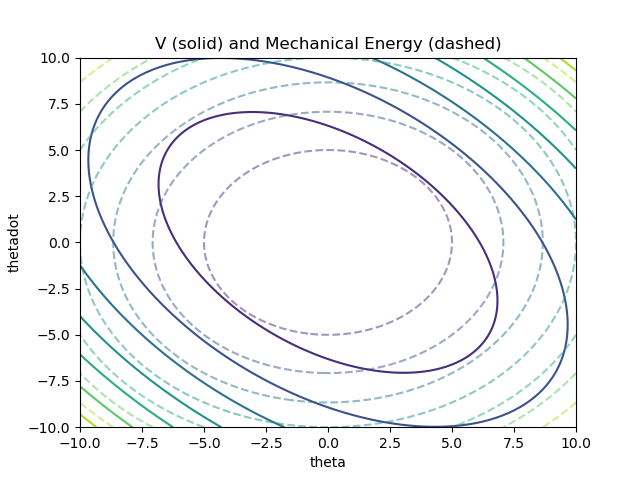

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

In [100]:
nq = 151
nqd = 151
lim = 10
qe = np.linspace(-lim, lim, nq)
qde = np.linspace(-lim, lim, nqd)
Q, QD = np.meshgrid(qe, qde)
Energy = .5 * m * QD**2 + k*Q**2
Vplot = Q.copy()
env = {q: 0., qdot:0}
for i in range(nq):
    for j in range(nqd):
        env[q] = Q[i, j]
        env[qdot] = QD[i, j]
        Vplot[i, j] = Vsol.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

HI
[-2.    3.14  0.    0.    0.  ]
[8.5656478  0.99562748 4.35330014 7.80659574]
[8.5656478  2.14596518 4.35330014 7.80659574]
[False False False False]
0.9956274785231782


<IPython.core.display.Javascript object>


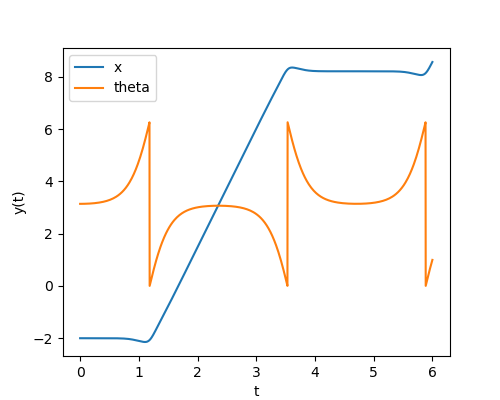

In [198]:
# testing both the controllers
def UprightState():
    return np.array([0, np.pi, 0, 0])

print('HI')
# defining the controller
x_ = Variable("x")
theta = Variable("t")
xdot = Variable("\dot{x}")
thetadot = Variable("\dot{t}")
u_symbolic = Variable("u")
garbage = Variable("garbage")

x = np.array([x_, theta, xdot, thetadot])

#K = -np.array([29.722, -1434.793/2, 70.189, -216.282])
K = 4
own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[K])

#defining the system
exp_dynamics = np.array([xdot, 
                         thetadot, 
                         K*thetadot*pf.cos(theta)*(0.5*mp*l**2*thetadot**2 - mp*gravity*l*pf.cos(theta) \
                                                   - mp*gravity*l),
                         (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])

system = SymbolicVectorSystem(state=x, input=np.array([u_symbolic]), dynamics=exp_dynamics, output=x)


builder = DiagramBuilder()
# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
# file_name = FindResource("models/cartpole.urdf")
# Parser(plant).AddModelFromFile(file_name)
# plant.Finalize()
# print('Plant Finalised')

plant = builder.AddSystem(system)
wrapangles = WrapToSystem(4)
wrapangles.set_interval(1, 0, 2*np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(plant.get_output_port(0), wrapto.get_input_port(0))
controller = builder.AddSystem(own_controller)
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                plant.get_input_port())

logger = LogVectorOutput(wrapto.get_output_port(), builder)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
#plant_context = plant.GetMyMutableContextFromRoot(context)

# Simulate
simulator.set_target_realtime_rate(0)
duration = 6

for i in range(1):
    context.SetTime(0.)
#     plant.SetPositionsAndVelocities(
#         plant_context,
#         UprightState() + 0.9 * np.random.randn(4,))
    trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
    trial = np.array([-2, 3.14, 0, 0, 0])
    print(trial)
    context.SetContinuousState(trial)
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    
    log = logger.FindLog(context)
    
    end_state = log.data()[:, -1]
    print(end_state)
    diff = np.abs(end_state - UprightState())
    print(diff)
    print(diff < np.ones(4)*5e-2)
    print(log.data()[1][-1])
    plt.figure(figsize=(5, 4))
    hmm = plt.plot(log.sample_times(), log.data().transpose()[:, :2])
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend(iter(hmm), ('x', 'theta'))

In [173]:
plt.plot(np.ones(5))

In [179]:
import matplotlib.pyplot as plt
plt.plot(np.ones(5))
plt.show()